In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")
import catboost as cb
import xgboost as xgb
import plotly.offline as pyo
import plotly.graph_objs as go
from scipy import stats

In [31]:
train=pd.read_csv("train_6BJx641.csv")
test=pd.read_csv("test_pavJagI.csv")

In [32]:
def datetime(data):
    data["datetime"]=pd.to_datetime(data["datetime"],format="%Y-%m-%d %H:%M:%S")
    data["year"]=data["datetime"].dt.year
    data["month"]=data["datetime"].dt.month
    data["day"]=data["datetime"].dt.day
    data["dow"]=data["datetime"].dt.dayofweek
    data["hour"]=data["datetime"].dt.hour
    data["weekend"]=data["dow"].apply(lambda x:1 if x in [5,6] else 0)
    data["imp_month"]=data["month"].apply(lambda x:1 if x in [7,8] else 0)
    return data

In [33]:
def grp_fun(data):    
    month_hour_grp=train_df.groupby(['month',"hour"]).agg({"electricity_consumption":["mean","std"]}).reset_index()
    month_hour_grp.columns=["month","hour","mean","std"]
    data=pd.merge(left=data,right=month_hour_grp,on=["month","hour"],how="left")
    return data

In [34]:
train_df=datetime(train)
test_df=datetime(test)

train_df=grp_fun(train_df)
test_df=grp_fun(test_df)

In [36]:
train_df["Data"]="Train"
test_df["Data"]="Test"

df=pd.concat([train_df,test_df])
df["temperature_bin"]=pd.qcut(df["temperature"],5,labels=[1,2,3,4,5]).astype(int)
df["pressure_bin"]=pd.qcut(df["pressure"],5,labels=[1,2,3,4,5]).astype(int)
df["windspeed_bin"]=pd.qcut(df["windspeed"],5,labels=[1,2,3,4,5]).astype(int)
df["var1_bin"]=pd.qcut(df["var1"],5,labels=[1,2,3,4,5]).astype(int)

In [38]:
df_dummies=df.copy()
df_dummies=df_dummies.sort_values(by="datetime")
df_dummies["lag"]=df_dummies["electricity_consumption"].shift()
df_dummies=df_dummies.drop(columns=["datetime","ID"])
df_dummies["var2"]=df_dummies["var2"].map({"A":0,"B":1,"C":2})
train_final=df_dummies[df_dummies["Data"]=="Train"]
test_final=df_dummies[df_dummies["Data"]=="Test"]
train_final=train_final.drop(columns=["Data"])
test_final=test_final.drop(columns=["Data","electricity_consumption"])

In [43]:
train_final.dropna(inplace=True)
X=train_final.drop(columns=["electricity_consumption"])
y=train_final["electricity_consumption"]
model=lgb.LGBMRegressor()
results=cross_val_score(estimator=model,X=X,y=y,cv=3,scoring="neg_mean_squared_error",n_jobs=-1)
(results*-1).mean()**.5

In [47]:
model.fit(X,y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

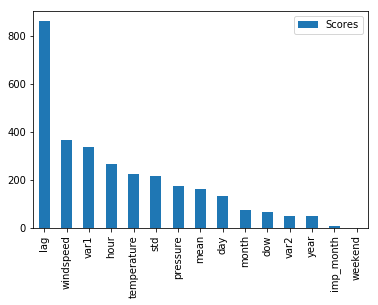

In [48]:
pd.DataFrame(data=model.feature_importances_,index=X.columns,
             columns=["Scores"]).sort_values("Scores",ascending=False)[:15].plot.bar()

In [49]:
lgb_model=lgb.LGBMRegressor().fit(X,y)
cat_model=cb.CatBoostRegressor().fit(X,y)
#xgb_model=xgb.XGBRegressor().fit(X,y)

0:	learn: 105.2455222	total: 10.1ms	remaining: 10.1s
1:	learn: 102.6353269	total: 16.2ms	remaining: 8.1s
2:	learn: 100.0951981	total: 23ms	remaining: 7.65s
3:	learn: 97.6296162	total: 29.4ms	remaining: 7.32s
4:	learn: 95.2541597	total: 36.8ms	remaining: 7.32s
5:	learn: 92.8515901	total: 44.1ms	remaining: 7.31s
6:	learn: 90.5294606	total: 51.5ms	remaining: 7.31s
7:	learn: 88.4376974	total: 60.7ms	remaining: 7.53s
8:	learn: 86.2919296	total: 70.5ms	remaining: 7.76s
9:	learn: 84.3165643	total: 77.6ms	remaining: 7.68s
10:	learn: 82.3713748	total: 85.7ms	remaining: 7.71s
11:	learn: 80.4186533	total: 92.1ms	remaining: 7.59s
12:	learn: 78.5128166	total: 99.2ms	remaining: 7.53s
13:	learn: 76.7063021	total: 106ms	remaining: 7.48s
14:	learn: 74.9370587	total: 114ms	remaining: 7.5s
15:	learn: 73.2398355	total: 121ms	remaining: 7.41s
16:	learn: 71.6133477	total: 127ms	remaining: 7.36s
17:	learn: 70.0049303	total: 133ms	remaining: 7.28s
18:	learn: 68.5196398	total: 140ms	remaining: 7.2s
19:	learn: 

162:	learn: 29.8772849	total: 1.25s	remaining: 6.45s
163:	learn: 29.8712335	total: 1.26s	remaining: 6.44s
164:	learn: 29.8625969	total: 1.27s	remaining: 6.43s
165:	learn: 29.8523253	total: 1.28s	remaining: 6.42s
166:	learn: 29.8423417	total: 1.28s	remaining: 6.4s
167:	learn: 29.8340261	total: 1.29s	remaining: 6.39s
168:	learn: 29.8226521	total: 1.3s	remaining: 6.37s
169:	learn: 29.8165508	total: 1.3s	remaining: 6.36s
170:	learn: 29.8085318	total: 1.31s	remaining: 6.34s
171:	learn: 29.8077484	total: 1.32s	remaining: 6.34s
172:	learn: 29.7992538	total: 1.32s	remaining: 6.33s
173:	learn: 29.7943222	total: 1.33s	remaining: 6.32s
174:	learn: 29.7867099	total: 1.34s	remaining: 6.33s
175:	learn: 29.7763968	total: 1.36s	remaining: 6.35s
176:	learn: 29.7706266	total: 1.36s	remaining: 6.35s
177:	learn: 29.7629252	total: 1.37s	remaining: 6.34s
178:	learn: 29.7588609	total: 1.38s	remaining: 6.32s
179:	learn: 29.7488918	total: 1.39s	remaining: 6.31s
180:	learn: 29.7404752	total: 1.39s	remaining: 6.

322:	learn: 28.9977100	total: 2.46s	remaining: 5.16s
323:	learn: 28.9907609	total: 2.47s	remaining: 5.16s
324:	learn: 28.9853369	total: 2.48s	remaining: 5.15s
325:	learn: 28.9800937	total: 2.48s	remaining: 5.14s
326:	learn: 28.9765765	total: 2.49s	remaining: 5.13s
327:	learn: 28.9670010	total: 2.5s	remaining: 5.12s
328:	learn: 28.9648238	total: 2.51s	remaining: 5.11s
329:	learn: 28.9585103	total: 2.51s	remaining: 5.1s
330:	learn: 28.9553691	total: 2.53s	remaining: 5.11s
331:	learn: 28.9528299	total: 2.54s	remaining: 5.1s
332:	learn: 28.9495430	total: 2.54s	remaining: 5.09s
333:	learn: 28.9441409	total: 2.55s	remaining: 5.08s
334:	learn: 28.9400760	total: 2.55s	remaining: 5.07s
335:	learn: 28.9371362	total: 2.56s	remaining: 5.06s
336:	learn: 28.9325297	total: 2.57s	remaining: 5.06s
337:	learn: 28.9270935	total: 2.58s	remaining: 5.05s
338:	learn: 28.9240769	total: 2.58s	remaining: 5.04s
339:	learn: 28.9195027	total: 2.59s	remaining: 5.03s
340:	learn: 28.9159060	total: 2.6s	remaining: 5.0

501:	learn: 28.2521490	total: 3.68s	remaining: 3.65s
502:	learn: 28.2493607	total: 3.69s	remaining: 3.65s
503:	learn: 28.2456891	total: 3.7s	remaining: 3.64s
504:	learn: 28.2403171	total: 3.71s	remaining: 3.63s
505:	learn: 28.2372517	total: 3.71s	remaining: 3.63s
506:	learn: 28.2309214	total: 3.72s	remaining: 3.62s
507:	learn: 28.2238138	total: 3.73s	remaining: 3.61s
508:	learn: 28.2199279	total: 3.73s	remaining: 3.6s
509:	learn: 28.2137024	total: 3.74s	remaining: 3.59s
510:	learn: 28.2109066	total: 3.75s	remaining: 3.58s
511:	learn: 28.2071676	total: 3.75s	remaining: 3.58s
512:	learn: 28.2000556	total: 3.76s	remaining: 3.57s
513:	learn: 28.1979240	total: 3.77s	remaining: 3.56s
514:	learn: 28.1947111	total: 3.77s	remaining: 3.55s
515:	learn: 28.1922307	total: 3.78s	remaining: 3.54s
516:	learn: 28.1875608	total: 3.79s	remaining: 3.54s
517:	learn: 28.1842024	total: 3.79s	remaining: 3.53s
518:	learn: 28.1809756	total: 3.8s	remaining: 3.52s
519:	learn: 28.1779398	total: 3.81s	remaining: 3.

666:	learn: 27.6742391	total: 4.92s	remaining: 2.45s
667:	learn: 27.6687194	total: 4.92s	remaining: 2.45s
668:	learn: 27.6641020	total: 4.93s	remaining: 2.44s
669:	learn: 27.6609193	total: 4.94s	remaining: 2.43s
670:	learn: 27.6581833	total: 4.95s	remaining: 2.43s
671:	learn: 27.6550343	total: 4.96s	remaining: 2.42s
672:	learn: 27.6511731	total: 4.97s	remaining: 2.41s
673:	learn: 27.6469418	total: 4.97s	remaining: 2.41s
674:	learn: 27.6435603	total: 4.98s	remaining: 2.4s
675:	learn: 27.6406300	total: 4.99s	remaining: 2.39s
676:	learn: 27.6381424	total: 5s	remaining: 2.38s
677:	learn: 27.6347748	total: 5s	remaining: 2.38s
678:	learn: 27.6323299	total: 5.01s	remaining: 2.37s
679:	learn: 27.6301272	total: 5.02s	remaining: 2.36s
680:	learn: 27.6279889	total: 5.03s	remaining: 2.35s
681:	learn: 27.6254879	total: 5.04s	remaining: 2.35s
682:	learn: 27.6212472	total: 5.05s	remaining: 2.34s
683:	learn: 27.6186980	total: 5.06s	remaining: 2.34s
684:	learn: 27.6145551	total: 5.06s	remaining: 2.33s


840:	learn: 27.1614416	total: 6.32s	remaining: 1.19s
841:	learn: 27.1585074	total: 6.33s	remaining: 1.19s
842:	learn: 27.1553299	total: 6.33s	remaining: 1.18s
843:	learn: 27.1511970	total: 6.34s	remaining: 1.17s
844:	learn: 27.1474226	total: 6.35s	remaining: 1.16s
845:	learn: 27.1458663	total: 6.36s	remaining: 1.16s
846:	learn: 27.1442947	total: 6.36s	remaining: 1.15s
847:	learn: 27.1412723	total: 6.37s	remaining: 1.14s
848:	learn: 27.1397738	total: 6.38s	remaining: 1.13s
849:	learn: 27.1380919	total: 6.39s	remaining: 1.13s
850:	learn: 27.1355442	total: 6.39s	remaining: 1.12s
851:	learn: 27.1332510	total: 6.41s	remaining: 1.11s
852:	learn: 27.1323520	total: 6.41s	remaining: 1.1s
853:	learn: 27.1298239	total: 6.42s	remaining: 1.1s
854:	learn: 27.1283849	total: 6.43s	remaining: 1.09s
855:	learn: 27.1245100	total: 6.44s	remaining: 1.08s
856:	learn: 27.1226592	total: 6.44s	remaining: 1.07s
857:	learn: 27.1191052	total: 6.45s	remaining: 1.07s
858:	learn: 27.1148626	total: 6.46s	remaining: 1

In [50]:
val=[]
test_change=test_final.copy()
for i in range(len(test_change)):
    if pd.isnull(test_change.iloc[i]["lag"]):
        test_change.iloc[i]=test_change.iloc[i].fillna(val[i-1][0])
        predictions=lgb_model.predict(test_change.iloc[i].values.reshape(1,-1))
        val.append(predictions)
    else:
        predictions=lgb_model.predict(test_change.iloc[i].values.reshape(1,-1))
        val.append(predictions)
lgb_pred=[i[0] for i in val]

In [51]:
test_change=test_final.copy()
val=[]
for i in range(len(test_final)):
    if pd.isnull(test_change.iloc[i]["lag"]):
        test_change.iloc[i]=test_change.iloc[i].fillna(val[i-1][0])
        predictions=cat_model.predict(test_change.iloc[i].values.reshape(1,-1))
        val.append(predictions)
    else:
        predictions=cat_model.predict(test_change.iloc[i].values.reshape(1,-1))
        val.append(predictions)

cat_pred=[i[0] for i in val]

In [52]:
pred=[(cat_pred[i]+lgb_pred[i])/2 for i in range(len(cat_pred))]

sub=pd.read_csv("sample_submission_bYgKb77.csv")

sub["electricity_consumption"]=cat_pred

sub.to_csv("sub9.csv",index=False)